# Решение задачи №5. ПРОИЗВОДСТВО. Команда: **plugg1N**


## Наша цель:
Cоздать модель, которая сможет предсказать фактор y=Result с наибольшим F1-score. Ориниентируясь на лидреборды, нам нужно набрать миниум 0.91 f1-score на валидац. выборке.

## Задачи:
- Выбрать факторы, которые смогут нам помочь в решении задания и провести Feature-Engineering
- Подготовить данные к началу обучения модели
- Подобрать идеальную мат.модель МО
- Затюнить модель для максимального результата

___
# Импорт нужных библиотек

In [68]:
# Модели
from lightgbm import LGBMClassifier

# Инструменты
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold

# Тюнинг
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

# Анализ данных
import pandas as pd
import seaborn as sns

# Факторы
from sklearn.preprocessing import RobustScaler, SplineTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.base import TransformerMixin, BaseEstimator

# Линейная алгебра
import numpy as np

# Скоринг
from sklearn.metrics import make_scorer, f1_score
from functools import partial

# Отображение
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

___
# Импортируем данные

*Переименовал `y` в `Result`, потому что так удобнее смотреть на данные*

In [69]:
train_data = pd.read_csv('train_AIC.csv').sort_index().rename(columns={'y': 'Result'})
test_data = pd.read_csv('test_AIC.csv').sort_index().rename(columns={'y': 'Result'})

## Первое на что хочется посмотреть...

так это на распределение значений `Result` по всему датасету. Если будет сильный дисбаланс в классах, то у нас будет модель с `bias`-ом, то есть она будет предпочитать одно значение больше, чем другое

<Axes: xlabel='Result', ylabel='Count'>

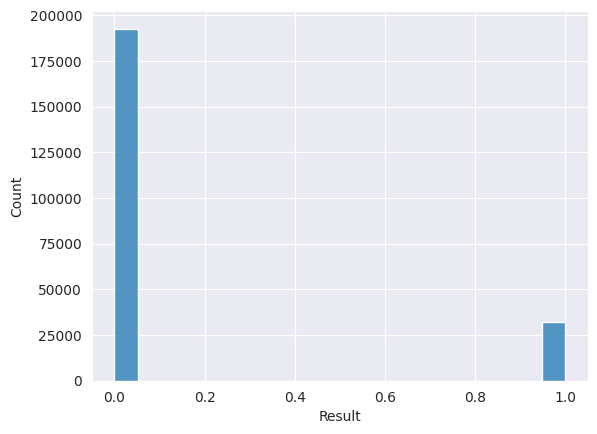

In [70]:
sns.histplot(train_data['Result'])

Как мы видим, у нас сильный дисбаланс в классах. Нулей намного больше, чем единиц. Наша мат. модель, может делать сильный уклон в нули, хотя она должна быть честна по отношению ко всем значениям `y`

___
# Feature-engineering

Давайте посмотрим, какие колонки можно убрать из расчетов

In [72]:
# Получаем информацию о каждом факторе в таблице
data_description = train_data.describe()

# Проходимся по факторам и выписываем то, что нас интересует: ['count', 'mean', 'min', 'max']
for i in train_data.columns[:-1]:
    for j in ['count', 'mean', 'min', 'max']:
        print(f"{i}:{j} = {data_description[i][j]}")
    print()

Поставщик:count = 225000.0
Поставщик:mean = 258.76450222222223
Поставщик:min = 1.0
Поставщик:max = 2720.0

Материал:count = 225000.0
Материал:mean = 12178.154022222223
Материал:min = 1.0
Материал:max = 27439.0

Категорийный менеджер:count = 225000.0
Категорийный менеджер:mean = 2.4915644444444442
Категорийный менеджер:min = 1.0
Категорийный менеджер:max = 15.0

Операционный менеджер:count = 225000.0
Операционный менеджер:mean = 7.406546666666666
Операционный менеджер:min = 1.0
Операционный менеджер:max = 38.0

Завод:count = 225000.0
Завод:mean = 4.12228
Завод:min = 1.0
Завод:max = 82.0

Закупочная организация:count = 225000.0
Закупочная организация:mean = 3.0072044444444446
Закупочная организация:min = 1.0
Закупочная организация:max = 26.0

Группа закупок:count = 225000.0
Группа закупок:mean = 46.753933333333336
Группа закупок:min = 1.0
Группа закупок:max = 379.0

Балансовая единица:count = 225000.0
Балансовая единица:mean = 2.715448888888889
Балансовая единица:min = 1.0
Балансовая еди

___
Создадим класс `DataPreprocessor`, который будет нужен для построения `sklearn.pipeline`-а, а так же для преобразования данных

- Сложим некоторые колонки в одну
- Уберем те колонки (как `Материал` и `Поставщик`), потому что они могут стать причиной галлюцинаций у модели. ID материала и поставщика вряд ли влияет на окончательное решение модели

In [75]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, transform_test=True):
        self.transform_test = transform_test


    # просто возвращает себя
    def fit(self, X, y=None):
        return self

    # преобразует данные
    def transform(self, X):
        data = X.copy()

        # когда мы закидываем данные для сабмита, то мы уже предполагаем,
        # что данные обработаны, поэтому их преобразовывать нет смысла
        if self.transform_test:
            return data


        ## Сумма 'Месяц1' и 'Месяц2'
        for i in range(3):
            num1 = int(data.iloc[i, 14]) + int(data.iloc[i, 15]) + int(data.iloc[i, 16])
            data.loc[i, 'Месяц3'] = num1
        data = data.drop(data.columns[[14, 15]], axis=1)

        ## Убираем лишние дни, кроме последних двух
        for i in range(3):
            num1 = int(data.iloc[i, 33]) + int(data.iloc[i, 34]) + int(data.iloc[i, 35]) + int(data.iloc[i, 36]) + int(data.iloc[i, 37])
            data.loc[i, 'Дней между 4_5'] = num1
        for i in range(3):
            num1 = int(data.iloc[i, 38]) + int(data.iloc[i, 39]) + int(data.iloc[i, 40])
            data.loc[i, 'Дней между 7_8'] = num1
        data = data.drop(data.columns[[33, 34, 35, 36, 38, 39]], axis=1)

        ## Складываем согласования
        for i in range(3):
            num1 = int(data.iloc[i, 22]) + int(data.iloc[i, 23]) + int(data.iloc[i, 24])
            data.loc[i, 'Согласование заказа 1'] = num1
        data = data.drop(data.columns[[23, 24]], axis=1)


        ## Убираем колонки, которые не рекомендуется рассматривать, и которые точно не имеет
        # смысла оставлять

        data = data.drop(columns=['Материал', 'Поставщик', 'Количество позиций'])


        return data


In [76]:
data_transformer = DataPreprocessor(transform_test=False)
data = data_transformer.transform(train_data)

In [77]:
data.sample(2)

,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,Вариант поставки,НРП,...,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 4_5,Дней между 7_8,Result
79018,1,7,1,1,4,1,1,11,2,0.0,...,0.0,0.0,0,0,0,1.0,9,0.0,-1.0,0
137324,2,3,4,1,2,1,1,2,2,0.0,...,4.0,4.0,1,1,1,2.0,19,-1.0,-1.0,0


___

## Теперь нам нужно решить проблему с дисбалансом классов
Буду использовать [ADASYN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html), как улучшенный SMOTE алгоритм, который позволит создать синтетические данные для обучения нашей модели без потери данных в UnderSample

In [49]:
X = data.iloc[:, :-1]
y = data['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

adasyn = ADASYN(sampling_strategy='minority', random_state=0)
X_train, y_train = adasyn.fit_resample(X_train, y_train)
print("Class distribution after ADASYN:", Counter(y_train))

Class distribution after ADASYN: Counter({1: 179466, 0: 173385})


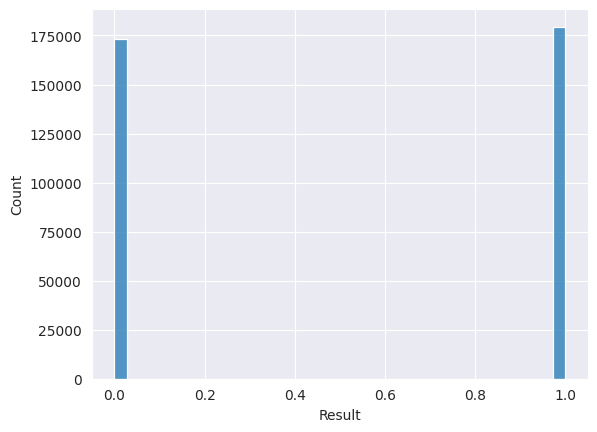

In [79]:
sns.histplot(y_train);

Теперь, дисбаланса в классах нет, так как значений 0 примерно столько же, как 1

___

# Теперь начнем подбирать параметры для обучения нашей модели на базе LGBMClassifier

In [81]:
datetime_preproc = DataPreprocessor()  # Трансформер
spline = SplineTransformer()  # Сплайн
estimator_lgbm = LGBMClassifier(n_jobs=-1)  # Модель

In [82]:
# Define the scoring metric as 'f1'
scoring = {
    'f1': make_scorer(f1_score, average='binary')
}

def objective(params, pipeline, X, y):
    pipeline.set_params(**params)
    cv_scores = cross_validate(pipeline, X, y, scoring=scoring, cv=3, n_jobs=-1)
    mean_f1 = cv_scores['test_f1'].mean()
    return {'loss': -mean_f1, 'params': params, 'status': STATUS_OK}

X_train_preproc = datetime_preproc.transform(X_train)
X_train_preproc = spline.fit_transform(X_train_preproc)
optimize_fn = partial(objective, pipeline=estimator_lgbm, X=X_train_preproc, y=y_train)

Будем перебирать следующие параметры LGBMClassifier:

In [ ]:
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1500, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 25, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 16, 272, 16)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.1), np.log(0.7)),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 0.7),
    'max_bin': scope.int(hp.quniform('max_bin', 10, 156, 2))
}

Начнем `Trials` и подбор параметров для нашей модели

In [14]:
trials = Trials()
tune_lgbm = fmin(
    fn=optimize_fn,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
)

In [ ]:
tune_lgbm

___
# Лучшие параметры, после перебора:

{'learning_rate': 0.21749116621829656,
 'max_bin': 78.0,
 'max_depth': 14.0,
 'n_estimators': 1200.0,
 'num_leaves': 256.0,
 'reg_lambda': 0.1978057698370551}

In [52]:
lgbm_model = LGBMClassifier(
    learning_rate=0.21749116621829656,
    max_bin=78,
    max_depth=14,
    num_leaves=256,
    n_estimators=1200,
    reg_lambda=0.1978057698370551
    )

Теперь натренируем нашу модель на обработанных данных

In [ ]:
datetime_preproc = DataPreprocessor(transform_test=False)
spline = SplineTransformer()
scaler = RobustScaler()
pipeline = Pipeline([
    ('datetime', datetime_preproc),
    ('spline', spline),
    ('scaler', scaler),
    ('model', lgbm_model)
])

In [53]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 179466, number of negative: 173385
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.523405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8518
[LightGBM] [Info] Number of data points in the train set: 352851, number of used features: 214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508617 -> initscore=0.034471
[LightGBM] [Info] Start training from score 0.034471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Pipeline(steps=[('datetime', DataPreprocessor(transform_test=False)),
                ('spline', SplineTransformer()), ('scaler', RobustScaler()),
                ('model',
                 LGBMClassifier(learning_rate=0.21749116621829656, max_bin=78,
                                max_depth=14, n_estimators=1200, num_leaves=256,
                                reg_lambda=0.1978057698370551))])

___
# Пайплайн готов!
Он, сначала:
- Убирает лишние колонки и складывает факторы
- Применяет сплайн
- Применяет скайлер
- И тренирует модель

___
# Проверим нашу модель на кросс-валидации

In [ ]:
cv_score = cross_val_score(pipeline, X_train, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=1), n_jobs=-1)
cv_score.mean()

~ 0.8914124518743

In [ ]:
f1_score(y_test, pipeline.predict(X_test))

0.8117392029348007 - 0.891584

In [55]:
pipeline.score(X_test, y_test)

ValueError: ignored

___
# Результаты:

- `pipeline.score` *(Accuracy)*, показывает ~0.948. Модель, в целом, очень точна, но мы не смотрим на Accuracy, так как нас интересует $F1-score$

- `sklearn.metrics.f1_score` *(F1-score)*, показывает меньшее значение, так как, скорее всего, какой-то `bias` все еще остался. Но он намного меньше, чем был ранее

Удивительно, но на сайте соревнования **AIIJC** наша модель получила $F1-score$ - 0.89. В тренировке моделей есть частичка рандомности, и, скорее всего, на наших валидационных данных

0.9498222222222222

In [38]:
test_data = pd.read_csv('test_AIC.csv')

In [44]:
data_preproc = DataPreprocessor(transform_test=False)

In [45]:
preproc_data = data_preproc.transform(test_data)
preproc_data

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,...,Изменение даты поставки 7,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 4_5,Дней между 7_8
0,273,269,6,8,1,1,64,1,9,22,...,0.0,0.0,0.0,0,0,0,1.0,16,1.0,-3.0
1,499,27439,1,10,18,16,1,14,1,35,...,0.0,0.0,0.0,0,0,0,1.0,12,-4.0,-2.0
2,86,27439,2,2,1,1,172,1,1,26,...,3.0,3.0,3.0,0,1,1,1.0,12,3.0,-3.0
3,97,4064,2,4,7,1,22,6,3,46,...,2.0,2.0,2.0,0,1,1,1.0,16,0.0,1.0
4,117,27439,2,3,1,1,2,1,1,2,...,1.0,1.0,1.0,0,1,1,1.0,15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,255,6409,3,6,3,1,10,3,1,16,...,0.0,0.0,0.0,1,0,0,2.0,18,0.0,-1.0
24996,1,5827,1,1,7,1,46,6,1,13,...,4.0,4.0,4.0,1,1,1,2.0,0,0.0,-1.0
24997,8,6504,6,5,3,1,17,3,1,21,...,0.0,0.0,0.0,0,0,0,1.0,9,0.0,-1.0
24998,18,1309,7,17,1,1,44,1,1,142,...,0.0,0.0,0.0,2,0,0,3.0,31,0.0,-1.0


In [22]:
preds = pipeline.predict(preproc_data)

In [23]:
data = {
    'id': range(25000),  # IDs ranging from 0 to 24999
    'value': preds  # Replace with your pipeline predictions
}

df = pd.DataFrame(data)
df.to_csv('submit_newestest.csv', index=False)

In [24]:
df.tail(20)

,id,value
24980,24980,0
24981,24981,0
24982,24982,0
24983,24983,0
24984,24984,0
24985,24985,0
24986,24986,0
24987,24987,0
24988,24988,0
24989,24989,0
